## ENV SETUP

In [1]:
!pip install datasets transformers torch cadquery matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 52.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [torch]32m3/4 [torch]kx]


In [11]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
#import evaluate

In [12]:
# Load train and test splits of the dataset

train_ds, test_ds = load_dataset("CADCODER/GenCAD-Code", split=["train", "test"])

print("Dataset loaded!")
print(f"Train samples: {len(train_ds)}")
print(f"Test samples: {len(test_ds)}")


Dataset loaded!
Train samples: 147289
Test samples: 7355


In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import io


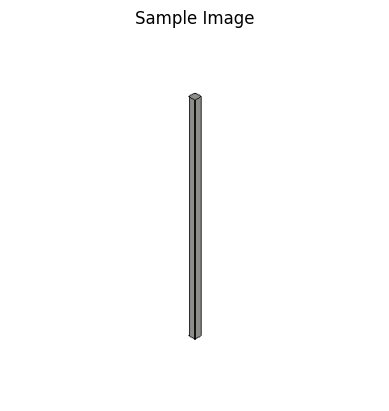


Corresponding CadQuery code:

import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.015625, -0.0078125, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop0=wp_sketch0.moveTo(0.0, 0.0).threePointArc((0.0007948582418457166, -0.0019189575476279677), (0.0027138157894736844, -0.0027138157894736844)).lineTo(0.021217105263157895, -0.0027138157894736844).threePointArc((0.022787161438489866, -0.00206347722796355), (0.0234375, -0.000493421052631579)).lineTo(0.0234375, 0.018256578947368422).threePointArc((0.02283825686147997, 0.019949990385858287), (0.021217105263157895, 0.020723684210526318)).lineTo(0.0022203947368421052, 0.020723684210526318).threePointArc((0.0005992431385200307, 0.019949990385858287), (0.0, 0.018256578947368422)).lineTo(0.0, 0.0).close()
solid0=wp_sketch0.add(loop0).extrude(0.75)
solid=solid0



In [13]:
sample = train_ds[0]

plt.imshow(sample['image'])
plt.axis('off')
plt.title("Sample Image")
plt.show()

print("\nCorresponding CadQuery code:\n")
print(sample['cadquery'])


In [15]:
#Load pretrained model and processors
model_name = "nlpconnect/vit-gpt2-image-captioning"  # image captioning model as baseline

model = VisionEncoderDecoderModel.from_pretrained(model_name)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/Users/dayanabenny/.venv/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (inte

In [22]:
class CadQueryDataset(Dataset):
    def __init__(self, hf_dataset, feature_extractor, tokenizer, max_target_length=128):
        self.dataset = hf_dataset
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        code = item['cadquery']
    
        # preprocess image
        pixel_values = self.feature_extractor(images=image, return_tensors="pt").pixel_values.squeeze()
    
        # tokenize code with padding and attention mask
        tokenized = self.tokenizer(code,
                                   max_length=self.max_target_length,
                                   padding="max_length",
                                   truncation=True,
                                   return_tensors="pt")
    
        labels = tokenized.input_ids.squeeze()
        attention_mask = tokenized.attention_mask.squeeze()
    
        # Replace pad token id with -100 to ignore in loss
        labels[labels == self.tokenizer.pad_token_id] = -100
    
        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "attention_mask": attention_mask
        }


# Create datasets and dataloaders

train_dataset = CadQueryDataset(train_ds, feature_extractor, tokenizer)
test_dataset = CadQueryDataset(test_ds, feature_extractor, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [50]:
model.eval()
generated_codes = []

for batch in test_loader:
    pixel_values = batch['pixel_values'].to(device)
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, max_length=128)
    preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    generated_codes.extend(preds)
    break  # demo only one batch

print("\nGenerated CadQuery code sample:\n")
print(generated_codes[0])


Generated CadQuery code sample:

a piece of paper with a mouse on it 


In [ ]:


from metrics.valid_syntax_rate import evaluate_syntax_rate_simple
from metrics.best_iou import get_iou_best

reference_code = test_ds[0]['cadquery']
generated_code = generated_codes[0]

vsr = evaluate_syntax_rate_simple({"sample_code": generated_code})
print(f"Valid Syntax Rate: {vsr}")

try:
    iou = get_iou_best(reference_code, generated_code)
    print(f"IOU between reference and generated: {iou}")
except Exception as e:
    print(f"IOU evaluation failed due to invalid generated code: {e}")



1. Install uv (or do it you're own way)
2. Run `uv sync`
3. Run `source .venv/bin/activate`

You're good to go.

# Instructions

The Task : Create the best CadQuery code generator model. 

1. Load the dataset (147K pairs of Images/CadQuery code).
2. Create a baseline model and evaluate it with the given metrics.
3. Enhance by any manner the baseline model and evaluate it again.
4. Explain you choices and possible bottlenecks. 
5. Show what enhancements you would have done if you had more time.

You can do *WHATEVER* you want, be creative, result is not what matters the most. 
Creating new model architectures, reusing ones you used in the past, fine-tuning, etc...

If you are GPU poor, there are solutions. Absolute value is not what matters, relative value between baseline and enhanced model is what matters.

In [1]:
from datasets import load_dataset
ds = load_dataset("CADCODER/GenCAD-Code", num_proc=16, split=["train", "test"], cache_dir="/Volumes/BIG-DATA/HUGGINGFACE_CACHE")

/Users/oweindourneau/projects/mecagent-technical-test/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Evaluation Metrics

1. Valid Syntax Rate metric assess the validity of the code by executing and checking if error are returned.
2. Best IOU assess the similarity between the meshes generated by the code.

In [2]:
from metrics.valid_syntax_rate import evaluate_syntax_rate_simple
from metrics.best_iou import get_iou_best

In [3]:
## Example usage of the metrics
sample_code = """
height = 60.0
width = 80.0
thickness = 10.0
diameter = 22.0

# make the base
result = (
    cq.Workplane("XY")
    .box(height, width, thickness)
)
"""

sample_code_2 = """
 height = 60.0
 width = 80.0
 thickness = 10.0
 diameter = 22.0
 padding = 12.0

 # make the base
 result = (
     cq.Workplane("XY")
     .box(height, width, thickness)
     .faces(">Z")
     .workplane()
     .hole(diameter)
     .faces(">Z")
     .workplane()
     .rect(height - padding, width - padding, forConstruction=True)
     .vertices()
     .cboreHole(2.4, 4.4, 2.1)
 )
"""
codes = {
    "sample_code": sample_code,
    "sample_code_2": sample_code_2,
}
vsr = evaluate_syntax_rate_simple(codes)
print("Valid Syntax Rate:", vsr)
iou = get_iou_best(sample_code, sample_code_2)
print("IOU:", iou)

Valid Syntax Rate: 1.0
IOU: 0.5834943417057687


## Have Fun